## Integrantes
#### Danny Valerio Ramírez

### Bibliotecas

In [1]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg


from sklearn import metrics
import seaborn as sns

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 1. Implementación del algoritmo de Kittler

## a)  Función para calcular_momentos_estadisticos(T,p) 

In [2]:
def calcular_momentos_estadisticos(T,M,p1=True):
    
    
    valores_unicos, conteo = torch.unique(M, return_counts=True)
    
    p_t=conteo/conteo.sum()
    
    if p1:
        p=p_t[valores_unicos<=T]
        M_u=valores_unicos[valores_unicos<=T]
    
    else:
        p=p_t[valores_unicos>T]
        M_u=valores_unicos[valores_unicos>T]
        
    p_sum=p.sum()
    e=((M_u*p).sum()) * (p_sum) ** (-1)
    
    v=(M_u-e)**2 
    v=(v*p).sum()* p.sum() ** (-1)
    
    print(f'P es de {p_sum}, hasta T = {T} ')
    print(f'La esperanza es de {e}, hasta T = {T} ')
    print(f'La varianza es de {v}, hasta T = {T} ')
    
    
    return e,v,p_sum


### Prueba 1

In [3]:
M = torch.tensor([25,25,50,50,90,100,120,150,190,200.0])
T= M.max()

print("mean_m ", M.mean())
print("Varianza:", M.var(unbiased=False))

mean_m  tensor(100.)
Varianza: tensor(3735.)


In [4]:
calcular_momentos_estadisticos(T,M)

P es de 1.0000001192092896, hasta T = 200.0 
La esperanza es de 99.99998474121094, hasta T = 200.0 
La varianza es de 3734.99951171875, hasta T = 200.0 


(tensor(100.0000), tensor(3734.9995), tensor(1.0000))

**En este caso tenemos un pequeña diferencia por los descimales**

### Prueba 2

In [5]:
M = torch.tensor([120.0, 121, 122, 123, 124,125])
T=M.max()

print("mean_m ", M.mean())
print("Varianza:", M.var(unbiased=False))

mean_m  tensor(122.5000)
Varianza: tensor(2.9167)


In [6]:
M = torch.tensor([120.0, 121, 122, 123, 124,125,126,127])
T=125

calcular_momentos_estadisticos(T,M)

P es de 0.75, hasta T = 125 
La esperanza es de 122.5, hasta T = 125 
La varianza es de 2.9166667461395264, hasta T = 125 


(tensor(122.5000), tensor(2.9167), tensor(0.7500))

## B)  Función para calcular_costo_J(T)

In [7]:
def calcular_costo_J(T,M):
    e1,v1,p1=calcular_momentos_estadisticos(T,M)
    e2,v2,p2=calcular_momentos_estadisticos(T,M,False)
    c = 1+  2 * ( p1 *   math.log(v1) +  p2 * math.log(v2)) - 2 * (math.log(p1)*p1 - math.log(p2)*p2)
    return c , e1 , v1 , e2 , v2

### Prueba 1

In [8]:
M = torch.tensor([25,25,50,50,90,100,120,150,190,200.0])
T= 100

In [9]:
c , e1 , v1 , e2 , v2=calcular_costo_J(T,M)
print(f'El costo es de {c}, hasta T = {T} ')

P es de 0.6000000238418579, hasta T = 100 
La esperanza es de 56.666664123535156, hasta T = 100 
La varianza es de 847.2222290039062, hasta T = 100 
P es de 0.4000000059604645, hasta T = 100 
La esperanza es de 165.0, hasta T = 100 
La varianza es de 1025.0, hasta T = 100 
El costo es de 14.51627254486084, hasta T = 100 


**Conociendo ya que la formula de la esperanza y varianza estan correctas usamos la formula en wolfram para comprobar**

![image.png](src/prueba1_costo.png)

### Prueba 2

In [10]:
M = torch.tensor([120.0, 121, 122, 123, 124,125])
T=  123

In [11]:
c , e1 , v1 , e2 , v2=calcular_costo_J(T,M)
print(f'El costo es de {c}, hasta T = {T} ')

P es de 0.6666666865348816, hasta T = 123 
La esperanza es de 121.5, hasta T = 123 
La varianza es de 1.25, hasta T = 123 
P es de 0.3333333432674408, hasta T = 123 
La esperanza es de 124.5, hasta T = 123 
La varianza es de 0.25, hasta T = 123 
El costo es de 0.1815403699874878, hasta T = 123 


**Conociendo ya que la formula de la esperanza y varianza estan correctas usamos la formula en wolfram para comprobar**

![image.png](src/prueba2_costo.png)

## c)  implementación de la función cal-cular_T_optimo_Kittler(Imagen)

In [12]:
def calcular_T_optimo_Kittler(Imagen):
    T_u= Imagen.unique()
    min_value = int(T_u.min().item())
    max_value = int(T_u.max().item())
    
    # si el T deja de bajar estamos en el valle
    #probamos el primer T
    T=min_value+1
    print(f'Para un T= {T}')
    costo_total_old , e1 ,v1 , e2 , v2 =calcular_costo_J(T,Imagen)
        
    #print(f'El costo total es de {costo_total_old}, hasta T = {T} ')  
    
    results=torch.tensor([costo_total_old])
    T_optimos=T
    e1_optimos=e1
    e2_optimos=e2
    v1_optimos=v1
    v2_optimos=v2
    
    for T in range(min_value+2, max_value-1):
        
        #print(f'Para un T= {T}')
        costo_total_NEW , e1 ,v1 , e2 , v2 =calcular_costo_J(T,Imagen)
        
        print(f'El costo total es de {costo_total_NEW}, hasta T = {T} ')  
        
        # si el T deja de bajar estamos en el valle
        if(costo_total_old>costo_total_NEW):
                T_optimos=T
                e1_optimos=e1
                e2_optimos=e2
                v1_optimos=v1
                v2_optimos=v2
            
        costo_total_old=costo_total_NEW
        results = torch.cat((results, torch.tensor([costo_total_old])))
        print(f'--------- ')
        
          
    # dejamos los optimos
    T=T_optimos
    e1=e1_optimos
    e2=e2_optimos
    v1=v1_optimos
    v2=v2_optimos 
    
    #umbrarizar imagen 
    umbralizada = torch.zeros(Imagen.shape)
    umbralizada = torch.where(Imagen >= T, umbralizada, 255)
 
    
    return T,e1,v1,e2,v2,umbralizada,results
    
        
    

## d) Aplicación del algoritmo de Kittler en la imagen cuadro1_005.bmp, pro-vista

**Abrimos la imagen**

In [13]:
U_1 = torch.tensor(np.array(Image.open('input/cuadro1_005.bmp').convert('L')))

U_1=U_1.float()
U_1

tensor([[219., 218., 219.,  ..., 221., 216., 217.],
        [220., 221., 220.,  ..., 222., 220., 225.],
        [216., 214., 220.,  ..., 222., 220., 220.],
        ...,
        [218., 219., 220.,  ..., 221., 221., 217.],
        [226., 219., 219.,  ..., 219., 224., 221.],
        [217., 223., 220.,  ..., 221., 225., 224.]])

### 1) Gráfico del histograma normalizado de la imagen de entrada provista

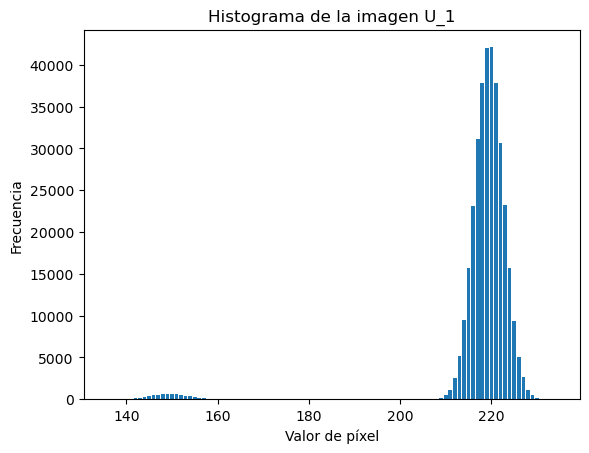

In [14]:
valores, conteos = torch.unique(U_1, return_counts=True)

# Crea el histograma
plt.bar(valores, conteos)
# Personaliza el gráfico
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')
plt.title('Histograma de la imagen U_1')

# Muestra el histograma

plt.show()

### 2) Gráfico la función

In [15]:
T,e1,v1,e2,v2,umbralizada,jt_func1=calcular_T_optimo_Kittler(U_1)

Para un T= 137
P es de 1.744287510518916e-05, hasta T = 137 
La esperanza es de 136.5, hasta T = 137 
La varianza es de 0.25, hasta T = 137 
P es de 0.9999825358390808, hasta T = 137 
La esperanza es de 218.1581573486328, hasta T = 137 
La varianza es de 101.8275375366211, hasta T = 137 
P es de 5.8142915804637596e-05, hasta T = 138 
La esperanza es de 137.5500030517578, hasta T = 138 
La varianza es de 0.5475000143051147, hasta T = 138 
P es de 0.9999418258666992, hasta T = 138 
La esperanza es de 218.16140747070312, hasta T = 138 
La varianza es de 101.57013702392578, hasta T = 138 
El costo total es de 10.24190902709961, hasta T = 138 
--------- 
P es de 0.00010465724335517734, hasta T = 139 
La esperanza es de 138.19444274902344, hasta T = 139 
La varianza es de 0.8233024477958679, hasta T = 139 
P es de 0.9998953342437744, hasta T = 139 
La esperanza es de 218.1650848388672, hasta T = 139 
La varianza es de 101.2833251953125, hasta T = 139 
El costo total es de 10.236544609069824,

P es de 0.019073784351348877, hasta T = 166 
La esperanza es de 149.45175170898438, hasta T = 166 
La varianza es de 15.366405487060547, hasta T = 166 
P es de 0.9809261560440063, hasta T = 166 
La esperanza es de 219.49269104003906, hasta T = 166 
La varianza es de 10.054693222045898, hasta T = 166 
El costo total es de 5.745520114898682, hasta T = 166 
--------- 
P es de 0.019073784351348877, hasta T = 167 
La esperanza es de 149.45175170898438, hasta T = 167 
La varianza es de 15.366405487060547, hasta T = 167 
P es de 0.9809261560440063, hasta T = 167 
La esperanza es de 219.49269104003906, hasta T = 167 
La varianza es de 10.054693222045898, hasta T = 167 
El costo total es de 5.745520114898682, hasta T = 167 
--------- 
P es de 0.019073784351348877, hasta T = 168 
La esperanza es de 149.45175170898438, hasta T = 168 
La varianza es de 15.366405487060547, hasta T = 168 
P es de 0.9809261560440063, hasta T = 168 
La esperanza es de 219.49269104003906, hasta T = 168 
La varianza es 

P es de 0.019073784351348877, hasta T = 189 
La esperanza es de 149.45175170898438, hasta T = 189 
La varianza es de 15.366405487060547, hasta T = 189 
P es de 0.9809261560440063, hasta T = 189 
La esperanza es de 219.49269104003906, hasta T = 189 
La varianza es de 10.054693222045898, hasta T = 189 
El costo total es de 5.745520114898682, hasta T = 189 
--------- 
P es de 0.019073784351348877, hasta T = 190 
La esperanza es de 149.45175170898438, hasta T = 190 
La varianza es de 15.366405487060547, hasta T = 190 
P es de 0.9809261560440063, hasta T = 190 
La esperanza es de 219.49269104003906, hasta T = 190 
La varianza es de 10.054693222045898, hasta T = 190 
El costo total es de 5.745520114898682, hasta T = 190 
--------- 
P es de 0.019073784351348877, hasta T = 191 
La esperanza es de 149.45175170898438, hasta T = 191 
La varianza es de 15.366405487060547, hasta T = 191 
P es de 0.9809261560440063, hasta T = 191 
La esperanza es de 219.49269104003906, hasta T = 191 
La varianza es 

P es de 0.8124250769615173, hasta T = 216 
La esperanza es de 220.47225952148438, hasta T = 216 
La varianza es de 6.136012554168701, hasta T = 216 
El costo total es de 6.479233264923096, hasta T = 216 
--------- 
P es de 0.27814698219299316, hasta T = 217 
La esperanza es de 211.01673889160156, hasta T = 217 
La varianza es de 282.3772888183594, hasta T = 217 
P es de 0.7218530774116516, hasta T = 217 
La esperanza es de 220.9079132080078, hasta T = 217 
La varianza es de 5.203336715698242, hasta T = 217 
El costo total es de 6.761692047119141, hasta T = 217 
--------- 
P es de 0.3881097733974457, hasta T = 218 
La esperanza es de 212.9953155517578, hasta T = 218 
La varianza es de 212.27371215820312, hasta T = 218 
P es de 0.6118902564048767, hasta T = 218 
La esperanza es de 221.4304656982422, hasta T = 218 
La varianza es de 4.3456950187683105, hasta T = 218 
El costo total es de 7.090391635894775, hasta T = 218 
--------- 
P es de 0.5102505683898926, hasta T = 219 
La esperanza e

In [16]:
print(T,e1,v1,e2,v2)

166 tensor(149.4518) tensor(15.3664) tensor(219.4927) tensor(10.0547)


## Gráfico de la función J(T)

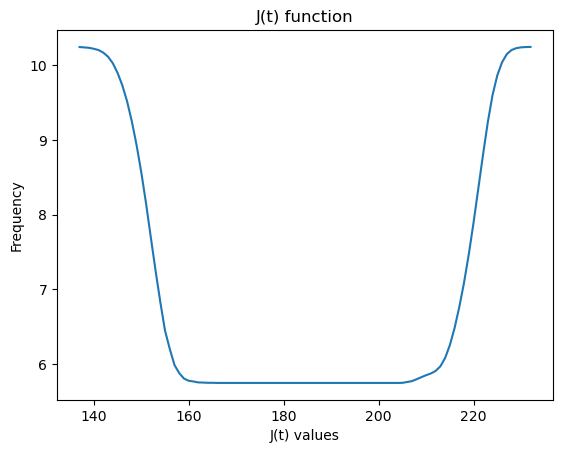

In [17]:
min_value = int(valores.min().item())+1
max_value = int(valores.max().item())-1
tensor_values = torch.arange(min_value, max_value)


plt.plot(tensor_values,jt_func1)
plt.xlabel('J(t) values')
plt.ylabel('Frequency')
plt.title('J(t) function')


plt.show()

## Gráfico de la función resultante

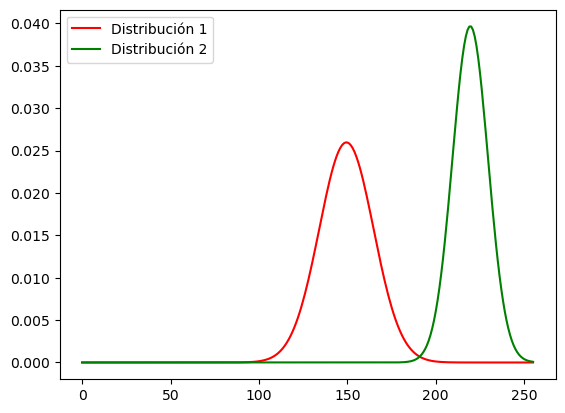

In [18]:
# Parámetros de la primera distribución bi-Gaussiana
mu1 = e1.numpy()
sigma1 = v1.numpy()

# Parámetros de la segunda distribución bi-Gaussiana
mu2 = e2.numpy()
sigma2 = v2.numpy()



# Graficar las curvas de las distribuciones bi-Gaussianas
x = torch.arange(256)
y1 = (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2)
y2 = (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)
plt.plot(x, y1, 'r', label='Distribución 1')
plt.plot(x, y2, 'g', label='Distribución 2')
plt.legend()

# Mostrar el histograma
plt.show()




### Aplicamos la función 1 antes de T y 2 después de T para unirlas

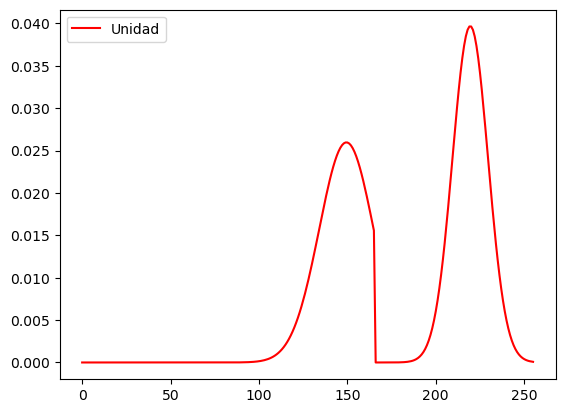

In [19]:
# Parámetros de la primera distribución bi-Gaussiana
mu1 = e1.numpy()
sigma1 = v1.numpy()

# Parámetros de la segunda distribución bi-Gaussiana
mu2 = e2.numpy()
sigma2 = v2.numpy()



# Graficar las curvas de las distribuciones bi-Gaussianas
x = torch.arange(256)
y1 = (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2)
y2 = (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)

Modelo1 = np.where(x < T, (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2), 
                    (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2))

plt.plot(x, Modelo1, 'r', label='Unidad')

plt.legend()

# Mostrar el histograma
plt.show()





## 3) hacemos el umbral de la imagen de entrada provista y mostramos los resultados

### Imagen original

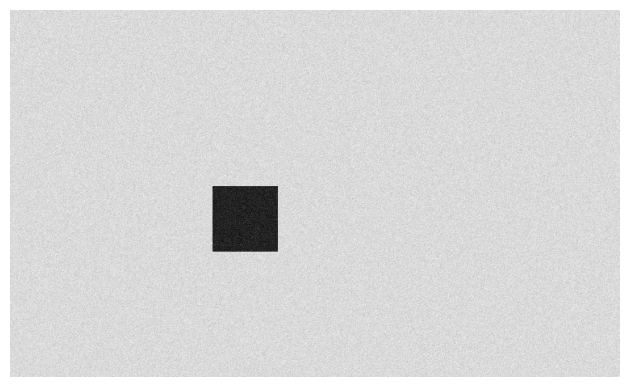

In [20]:
# Cargar la imagen desde un archivo

# Mostrar la imagen en un gráfico
plt.imshow(U_1, cmap='gray')


plt.axis('off')  # Desactivar los ejes
plt.tight_layout()  # Ajustar el diseño del gráfico

# Mostrar el gráfico con la imagen
plt.show()

### La nueva imagen umbralizada

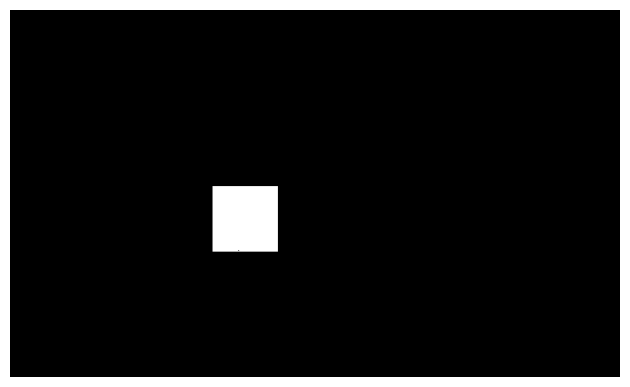

In [21]:
plt.imshow(umbralizada, cmap='gray')


plt.axis('off')  # Desactivar los ejes
plt.tight_layout()  # Ajustar el diseño del gráfico

# Mostrar el gráfico con la imagen
plt.show()

## 4) calcular_matriz_confusion

In [22]:
def plot_confusion_matrix(y_test, predicted):    
    """
    Displays the confusion matrix and other metrics.
    
    Parameters:
      y_test : a list of test data. 
      predicted: a list of model results
    """
    classes = np.unique(y_test)
    
    ## Accuracy, Precision, Recall
    accuracy = metrics.accuracy_score(y_test, predicted)

    print("Accuracy:",  round(accuracy,2))
    print("Details:")
    print(metrics.classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, predicted)
    plt.figure(figsize=(10, 8))  # Ajustar el tamaño de la figura
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
           yticklabels=classes, title="Confusion matrix")
    plt.xticks(rotation=90)  # Girar las etiquetas del eje x
    plt.yticks(rotation=0)

    plt.show()

**Creamos el ground truth**

In [23]:
ground_truth = torch.zeros(U_1.shape)
ground_truth = torch.where(U_1 >= 167, ground_truth, 255)
ground_truth_v = ground_truth.view(-1)
ground_truth_v

tensor([0., 0., 0.,  ..., 0., 0., 0.])

### Pasamos a verctor la imagne umbralizada

In [24]:
umbralizada_v=umbralizada.view(-1)

### Graficamos la matirz

Accuracy: 1.0
Details:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    337419
       255.0       1.00      1.00      1.00      6561

    accuracy                           1.00    343980
   macro avg       1.00      1.00      1.00    343980
weighted avg       1.00      1.00      1.00    343980



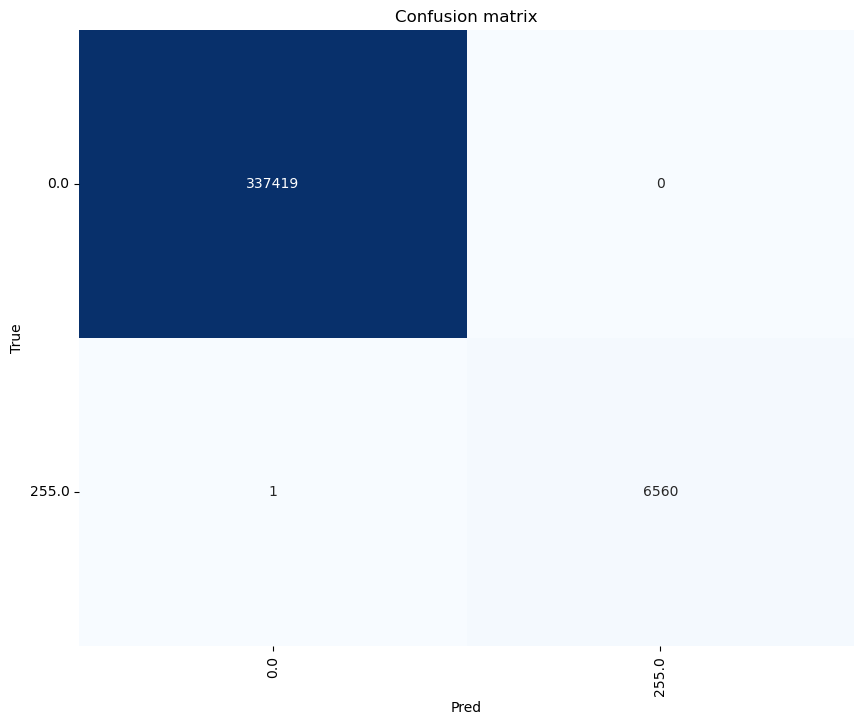

In [25]:
plot_confusion_matrix(ground_truth_v, umbralizada_v)

# 2 Cálculo del umbral óptimo con el algoritmo de Kittler, y se umbraliza la imagen de trackedCell15.tif

**Abrimos la imagen**

In [26]:
U_2 = torch.tensor(np.array(Image.open('input/trackedCell15.tif').convert('L')))

U_2=U_2.float()
U_2

tensor([[164., 153., 150.,  ...,   4.,   4.,   4.],
        [164., 151., 150.,  ...,   4.,   4.,   4.],
        [152., 142., 134.,  ...,   4.,   4.,   4.],
        ...,
        [ 35.,  37.,  36.,  ...,   4.,   4.,   4.],
        [ 32.,  36.,  34.,  ...,   4.,   4.,   4.],
        [ 29.,  32.,  31.,  ...,   4.,   4.,   4.]])

###  Graficamos el histograma normalizado de la imagen de entrada provista

In [ ]:
valores

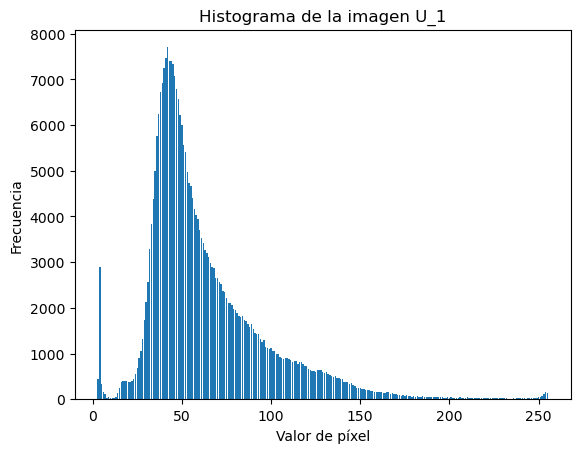

In [28]:
valores, conteos = torch.unique(U_2, return_counts=True)

# Crea el histograma
plt.bar(valores, conteos)
# Personaliza el gráfico
plt.xlabel('Valor de píxel')
plt.ylabel('Frecuencia')
plt.title('Histograma de la imagen U_1')

# Muestra el histograma

plt.show()

In [29]:
T,e1,v1,e2,v2,umbralizada,jt_func2=calcular_T_optimo_Kittler(U_2)

Para un T= 4
P es de 0.010930861346423626, hasta T = 4 
La esperanza es de 3.865246057510376, hasta T = 4 
La varianza es de 0.11659528315067291, hasta T = 4 
P es de 0.9890691041946411, hasta T = 4 
La esperanza es de 63.99711608886719, hasta T = 4 
La varianza es de 1082.6761474609375, hasta T = 4 
P es de 0.012059377506375313, hasta T = 5 
La esperanza es de 3.9714365005493164, hasta T = 5 
La varianza es de 0.21490775048732758, hasta T = 5 
P es de 0.9879406094551086, hasta T = 5 
La esperanza es de 64.06451416015625, hasta T = 5 
La varianza es de 1079.932373046875, hasta T = 5 
El costo total es de 14.846343040466309, hasta T = 5 
--------- 
P es de 0.012567865662276745, hasta T = 6 
La esperanza es de 4.053511142730713, hasta T = 6 
La varianza es de 0.36596983671188354, hasta T = 6 
P es de 0.9874321222305298, hasta T = 6 
La esperanza es de 64.09442138671875, hasta T = 6 
La varianza es de 1078.75146484375, hasta T = 6 
El costo total es de 14.851347923278809, hasta T = 6 
---

P es de 0.9599671363830566, hasta T = 28 
La esperanza es de 65.28059387207031, hasta T = 28 
La varianza es de 1058.33544921875, hasta T = 28 
El costo total es de 14.911761283874512, hasta T = 28 
--------- 
P es de 0.0457409992814064, hasta T = 29 
La esperanza es de 18.323530197143555, hasta T = 29 
La varianza es de 95.98777770996094, hasta T = 29 
P es de 0.9542589783668518, hasta T = 29 
La esperanza es de 65.49761962890625, hasta T = 29 
La varianza es de 1056.7454833984375, hasta T = 29 
El costo total es de 14.899300575256348, hasta T = 29 
--------- 
P es de 0.05272861197590828, hasta T = 30 
La esperanza es de 19.870901107788086, hasta T = 30 
La varianza es de 98.94091033935547, hasta T = 30 
P es de 0.9472713470458984, hasta T = 30 
La esperanza es de 65.75946807861328, hasta T = 30 
La varianza es de 1055.1768798828125, hasta T = 30 
El costo total es de 14.881007194519043, hasta T = 30 
--------- 
P es de 0.06114327907562256, hasta T = 31 
La esperanza es de 21.40251350

P es de 0.5360748171806335, hasta T = 55 
La esperanza es de 41.12595748901367, hasta T = 55 
La varianza es de 96.45008087158203, hasta T = 55 
P es de 0.46392521262168884, hasta T = 55 
La esperanza es de 89.00839233398438, hasta T = 55 
La varianza es de 1051.9635009765625, hasta T = 55 
El costo total es de 12.310893058776855, hasta T = 55 
--------- 
P es de 0.5505421161651611, hasta T = 56 
La esperanza es de 41.51682662963867, hasta T = 56 
La varianza es de 99.57652282714844, hasta T = 56 
P es de 0.44945791363716125, hasta T = 56 
La esperanza es de 90.07086944580078, hasta T = 56 
La varianza es de 1049.624755859375, hasta T = 56 
El costo total es de 12.257344245910645, hasta T = 56 
--------- 
P es de 0.5642352104187012, hasta T = 57 
La esperanza es de 41.892578125, hasta T = 57 
La varianza es de 102.83660125732422, hasta T = 57 
P es de 0.43576478958129883, hasta T = 57 
La esperanza es de 91.11006927490234, hasta T = 57 
La varianza es de 1047.160400390625, hasta T = 57

P es de 0.2121742069721222, hasta T = 82 
La esperanza es de 115.14614868164062, hasta T = 82 
La varianza es de 971.2060546875, hasta T = 82 
El costo total es de 12.204012870788574, hasta T = 82 
--------- 
P es de 0.7937176823616028, hasta T = 83 
La esperanza es de 49.63705825805664, hasta T = 83 
La varianza es de 236.43280029296875, hasta T = 83 
P es de 0.20628228783607483, hasta T = 83 
La esperanza es de 116.06431579589844, hasta T = 83 
La varianza es de 968.5872802734375, hasta T = 83 
El costo total es de 12.228618621826172, hasta T = 83 
--------- 
P es de 0.7996850609779358, hasta T = 84 
La esperanza es de 49.89348220825195, hasta T = 84 
La varianza es de 243.41416931152344, hasta T = 84 
P es de 0.20031492412090302, hasta T = 84 
La esperanza es de 117.01953125, hasta T = 84 
La varianza es de 965.9015502929688, hasta T = 84 
El costo total es de 12.25507640838623, hasta T = 84 
--------- 
P es de 0.8053801655769348, hasta T = 85 
La esperanza es de 50.141727447509766,

P es de 0.8927876949310303, hasta T = 106 
La esperanza es de 54.515708923339844, hasta T = 106 
La varianza es de 405.6292724609375, hasta T = 106 
P es de 0.10721233487129211, hasta T = 106 
La esperanza es de 136.82073974609375, hasta T = 106 
La varianza es de 927.03955078125, hasta T = 106 
El costo total es de 12.911811828613281, hasta T = 106 
--------- 
P es de 0.895677924156189, hasta T = 107 
La esperanza es de 54.68505859375, hasta T = 107 
La varianza es de 413.1801452636719, hasta T = 107 
P es de 0.1043221578001976, hasta T = 107 
La esperanza es de 137.64691162109375, hasta T = 107 
La varianza es de 927.4031982421875, hasta T = 107 
El costo total es de 12.942227363586426, hasta T = 107 
--------- 
P es de 0.898666501045227, hasta T = 108 
La esperanza es de 54.86236572265625, hasta T = 108 
La varianza es de 421.2276611328125, hasta T = 108 
P es de 0.10133355855941772, hasta T = 108 
La esperanza es de 138.52127075195312, hasta T = 108 
La varianza es de 928.067993164

P es de 0.9491380453109741, hasta T = 129 
La esperanza es de 58.23067092895508, hasta T = 129 
La varianza es de 602.77294921875, hasta T = 129 
P es de 0.05086196959018707, hasta T = 129 
La esperanza es de 158.68214416503906, hasta T = 129 
La varianza es de 996.8382568359375, hasta T = 129 
El costo total es de 13.650346755981445, hasta T = 129 
--------- 
P es de 0.9509916305541992, hasta T = 130 
La esperanza es de 58.37054443359375, hasta T = 130 
La varianza es de 611.61767578125, hasta T = 130 
P es de 0.04900845140218735, hasta T = 130 
La esperanza es de 159.76690673828125, hasta T = 130 
La varianza es de 1002.2488403320312, hasta T = 130 
El costo total es de 13.680603981018066, hasta T = 130 
--------- 
P es de 0.9529566764831543, hasta T = 131 
La esperanza es de 58.52031326293945, hasta T = 131 
La varianza es de 621.2115478515625, hasta T = 131 
P es de 0.04704338684678078, hasta T = 131 
La esperanza es de 160.96853637695312, hasta T = 131 
La varianza es de 1008.1029

P es de 0.9834954738616943, hasta T = 159 
La esperanza es de 61.12828826904297, hasta T = 159 
La varianza es de 815.9808959960938, hasta T = 159 
P es de 0.016504550352692604, hasta T = 159 
La esperanza es de 195.12405395507812, hasta T = 159 
La varianza es de 967.9436645507812, hasta T = 159 
El costo total es de 14.311680793762207, hasta T = 159 
--------- 
P es de 0.9840137958526611, hasta T = 160 
La esperanza es de 61.18037414550781, hasta T = 160 
La varianza es de 820.6978149414062, hasta T = 160 
P es de 0.01598622277379036, hasta T = 160 
La esperanza es de 196.2628631591797, hasta T = 160 
La varianza es de 958.0298461914062, hasta T = 160 
El costo total es de 14.324734687805176, hasta T = 160 
--------- 
P es de 0.984512448310852, hasta T = 161 
La esperanza es de 61.23093032836914, hasta T = 161 
La varianza es de 825.3262329101562, hasta T = 161 
P es de 0.01548757404088974, hasta T = 161 
La esperanza es de 197.3982391357422, hasta T = 161 
La varianza es de 947.5509

P es de 0.0083457725122571, hasta T = 184 
La esperanza es de 220.36399841308594, hasta T = 184 
La varianza es de 580.734619140625, hasta T = 184 
El costo total es de 14.545490264892578, hasta T = 184 
--------- 
P es de 0.9918543696403503, hasta T = 185 
La esperanza es de 62.04312515258789, hasta T = 185 
La varianza es de 908.0006713867188, hasta T = 185 
P es de 0.008145656436681747, hasta T = 185 
La esperanza es de 221.23281860351562, hasta T = 185 
La varianza es de 563.52294921875, hasta T = 185 
El costo total es de 14.55257797241211, hasta T = 185 
--------- 
P es de 0.9920183420181274, hasta T = 186 
La esperanza es de 62.06361770629883, hasta T = 186 
La varianza es de 910.3907470703125, hasta T = 186 
P es de 0.007981628179550171, hasta T = 186 
La esperanza es de 221.9568634033203, hasta T = 186 
La varianza es de 549.06884765625, hasta T = 186 
El costo total es de 14.558462142944336, hasta T = 186 
--------- 
P es de 0.9921922087669373, hasta T = 187 
La esperanza es 

P es de 0.00484212301671505, hasta T = 210 
La esperanza es de 237.8536376953125, hasta T = 210 
La varianza es de 231.2387237548828, hasta T = 210 
El costo total es de 14.689088821411133, hasta T = 210 
--------- 
P es de 0.9952596426010132, hasta T = 211 
La esperanza es de 62.5058708190918, hasta T = 211 
La varianza es de 967.4592895507812, hasta T = 211 
P es de 0.004740424919873476, hasta T = 211 
La esperanza es de 238.42974853515625, hasta T = 211 
La varianza es de 220.39730834960938, hasta T = 211 
El costo total es de 14.694043159484863, hasta T = 211 
--------- 
P es de 0.9953317642211914, hasta T = 212 
La esperanza es de 62.5167121887207, hasta T = 212 
La varianza es de 969.009765625, hasta T = 212 
P es de 0.0046682520769536495, hasta T = 212 
La esperanza es de 238.83837890625, hasta T = 212 
La varianza es de 212.83824157714844, hasta T = 212 
El costo total es de 14.697603225708008, hasta T = 212 
--------- 
P es de 0.9954302310943604, hasta T = 213 
La esperanza es

P es de 0.9971492290496826, hasta T = 234 
La esperanza es de 62.807613372802734, hasta T = 234 
La varianza es de 1013.6558837890625, hasta T = 234 
P es de 0.0028508161194622517, hasta T = 234 
La esperanza es de 249.49365234375, hasta T = 234 
La varianza es de 33.78505325317383, hasta T = 234 
El costo total es de 14.795526504516602, hasta T = 234 
--------- 
P es de 0.9971951246261597, hasta T = 235 
La esperanza es de 62.815547943115234, hasta T = 235 
La varianza es de 1014.9747314453125, hasta T = 235 
P es de 0.0028048879466950893, hasta T = 235 
La esperanza es de 249.73101806640625, hasta T = 235 
La varianza es de 30.842252731323242, hasta T = 235 
El costo total es de 14.798274993896484, hasta T = 235 
--------- 
P es de 0.9972902536392212, hasta T = 236 
La esperanza es de 62.83207321166992, hasta T = 236 
La varianza es de 1017.7388916015625, hasta T = 236 
P es de 0.0027097510173916817, hasta T = 236 
La esperanza es de 250.21311950683594, hasta T = 236 
La varianza es 

## Gráfico de la función J(T)

In [30]:
print(T,e1,v1,e2,v2)

68 tensor(45.5619) tensor(149.0951) tensor(102.0815) tensor(1014.1330)


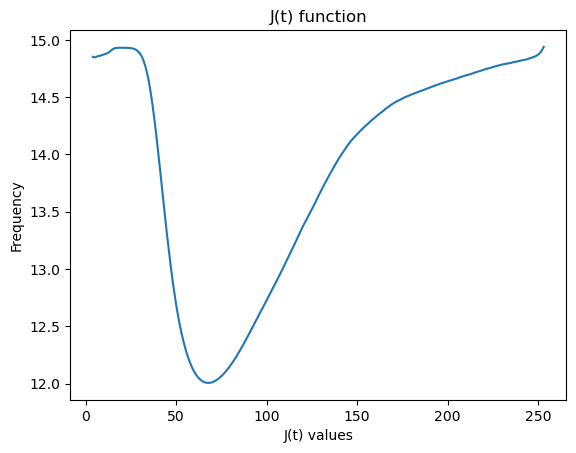

In [31]:
min_value = int(valores.min().item())+1
max_value = int(valores.max().item())-1
tensor_values = torch.arange(min_value, max_value)


plt.plot(tensor_values,jt_func2)
plt.xlabel('J(t) values')
plt.ylabel('Frequency')
plt.title('J(t) function')


plt.show()

## Gráfico de la funcion resultante

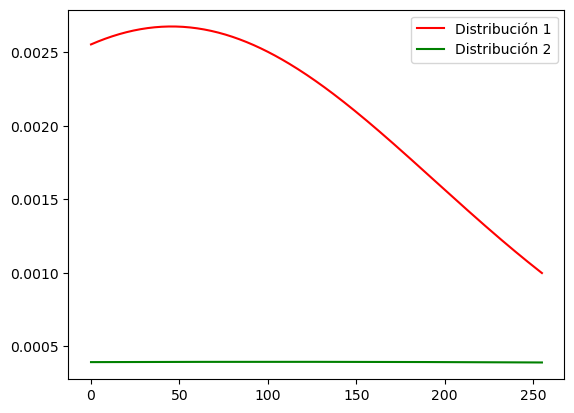

In [32]:
# Parámetros de la primera distribución bi-Gaussiana
mu1 = e1.numpy()
sigma1 = v1.numpy()

# Parámetros de la segunda distribución bi-Gaussiana
mu2 = e2.numpy()
sigma2 = v2.numpy()



# Graficar las curvas de las distribuciones bi-Gaussianas
x = torch.arange(256)
y1 = (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2)
y2 = (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)
plt.plot(x, y1, 'r', label='Distribución 1')
plt.plot(x, y2, 'g', label='Distribución 2')
plt.legend()

# Mostrar el histograma
plt.show()

### Apliciamos la funcion 1 antes de T y 2 despues de T para unirlas

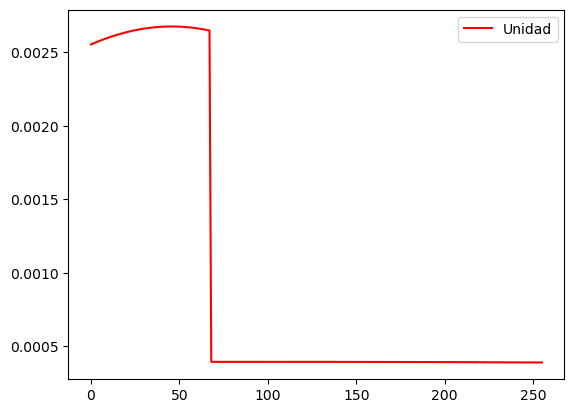

In [33]:
# Parámetros de la primera distribución bi-Gaussiana
mu1 = e1.numpy()
sigma1 = v1.numpy()

# Parámetros de la segunda distribución bi-Gaussiana
mu2 = e2.numpy()
sigma2 = v2.numpy()



# Graficar las curvas de las distribuciones bi-Gaussianas
x = torch.arange(256)
y1 = (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2)
y2 = (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2)

Modelo2 = np.where(x < T, (1 / (sigma1 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu1) / sigma1) ** 2), 
                    (1 / (sigma2 * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu2) / sigma2) ** 2))

plt.plot(x, Modelo2, 'r', label='Unidad')

plt.legend()

# Mostrar el histograma
plt.show()


### Imagen original

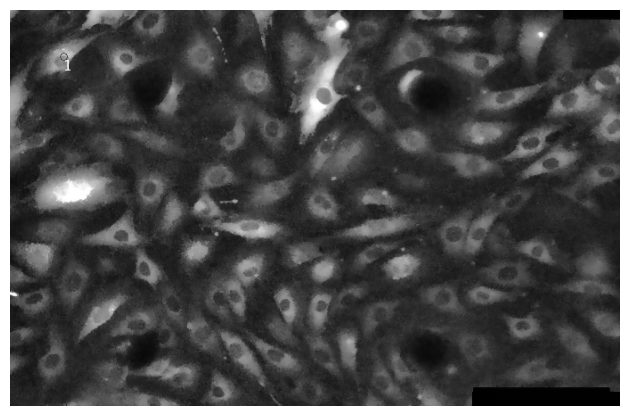

In [34]:
# Cargar la imagen desde un archivo

# Mostrar la imagen en un gráfico
plt.imshow(U_2, cmap='gray')


plt.axis('off')  # Desactivar los ejes
plt.tight_layout()  # Ajustar el diseño del gráfico

# Mostrar el gráfico con la imagen
plt.show()

### La nueva imagen umbralizada

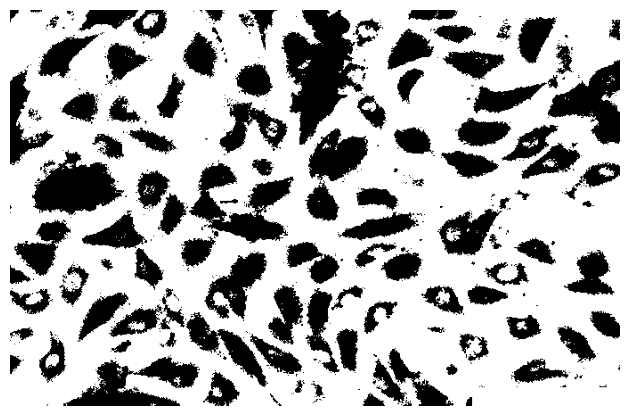

In [35]:
plt.imshow(umbralizada, cmap='gray')


plt.axis('off')  # Desactivar los ejes
plt.tight_layout()  # Ajustar el diseño del gráfico

# Mostrar el gráfico con la imagen
plt.show()

# 3) La función de Kullback-Leibler (KL)

## Generamos un histograma  con base en el modelo1

In [36]:
valores, Histograma1 = torch.unique(U_1, return_counts=True)

tensor_values = torch.arange(256)
mask = torch.isin(tensor_values, valores)
Histograma2 = Modelo1[mask]

print(Histograma2)

[1.76983335e-02 1.86962207e-02 1.96669056e-02 2.06005585e-02
 2.14873427e-02 2.23175842e-02 2.30819452e-02 2.37715984e-02
 2.43783955e-02 2.48950272e-02 2.53151700e-02 2.56336142e-02
 2.58463723e-02 2.59507611e-02 2.59454591e-02 2.58305334e-02
 2.56074387e-02 2.52789869e-02 2.48492876e-02 2.43236627e-02
 2.37085372e-02 2.30113077e-02 2.22401951e-02 2.14040838e-02
 2.05123513e-02 1.95746950e-02 1.86009581e-02 1.76009610e-02
 1.65843404e-02 2.83372183e-08 1.40409894e-02 1.61253026e-02
 1.83367435e-02 2.06462282e-02 2.30177786e-02 2.54091577e-02
 2.77729046e-02 3.00577530e-02 3.22103834e-02 3.41774338e-02
 3.59076664e-02 3.73541696e-02 3.84764651e-02 3.92423873e-02
 3.96296145e-02 3.96267495e-02 3.92338769e-02 3.84625590e-02
 3.73352704e-02 3.58843100e-02 3.41502645e-02 3.21801245e-02
 3.00251745e-02 2.77387915e-02 2.53742787e-02 2.29828589e-02
 2.06119257e-02 1.83036314e-02 1.60938566e-02 1.40115818e-02]


In [37]:
p=Histograma1/Histograma1.sum()
q=Histograma2/Histograma2.sum()

In [38]:
def calcular_kullback_leibler(p,q):
    
    termino = p * torch.log2(q /p )
            
    return -termino


KL = calcular_kullback_leibler(p,q)
print(KL)



tensor([-9.0562e-05, -9.1252e-05, -3.3836e-04, -3.8085e-04, -8.0548e-04,
        -9.9817e-04, -1.7331e-03, -2.4430e-03, -3.3493e-03, -4.2557e-03,
        -4.8673e-03, -5.4134e-03, -5.8589e-03, -5.9977e-03, -5.9920e-03,
        -5.8103e-03, -5.4281e-03, -4.7416e-03, -4.0172e-03, -3.3469e-03,
        -2.1965e-03, -1.8747e-03, -1.0567e-03, -7.5656e-04, -3.6084e-04,
        -1.4234e-04, -1.8790e-04, -3.4772e-05, -6.3230e-05,  2.1175e-05,
        -3.3824e-05, -2.8779e-04, -4.1078e-04, -1.1930e-03, -2.5510e-03,
        -5.2722e-03, -8.1482e-03, -1.0497e-02, -7.4849e-03,  7.7538e-03,
         4.3386e-02,  9.7657e-02,  1.6648e-01,  2.2977e-01,  2.7199e-01,
         2.7308e-01,  2.3021e-01,  1.6198e-01,  9.8287e-02,  4.3220e-02,
         7.4549e-03, -7.7167e-03, -1.0472e-02, -8.1543e-03, -4.8138e-03,
        -2.4294e-03, -1.0532e-03, -4.1064e-04, -8.9366e-05, -3.3815e-05],
       dtype=torch.float64)


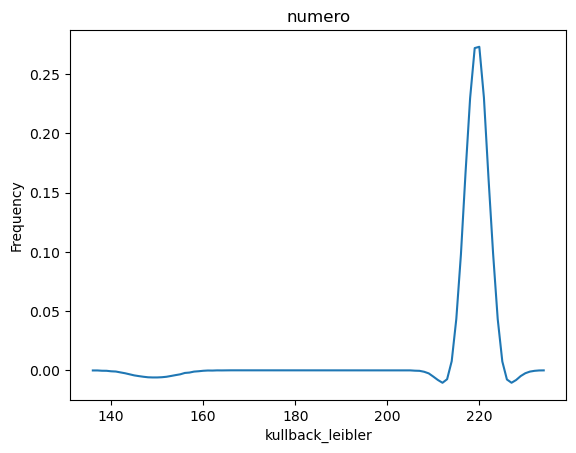

In [39]:
plt.plot(valores,KL)
plt.xlabel('kullback_leibler')
plt.ylabel('Frequency')
plt.title('numero')


plt.show()